# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings

# Configurations

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

# 2. Loading Data

In [3]:
df = pd.read_csv('profit_sharing_data.csv')

In [4]:
df.head()

,project_id,sector,invest_amount,duration_months,risk_level,expected_return_rate,success_prob,bank_share_ratio,investor_share_ratio,success_flag,actual_return_rate,bank_profit_loss,investor_profit_loss
0,1,İnşaat,244104.53,16,Yüksek,0.130,0.566,0.37,0.63,1,0.157,14180.03,24144.38
1,2,Sağlık,212689.10,6,Orta,0.092,0.698,0.44,0.56,1,0.102,9545.49,12148.80
2,3,Teknoloji,245073.96,18,Orta,0.096,0.735,0.48,0.52,1,0.080,9410.84,10195.08
3,4,Sağlık,89098.54,24,Yüksek,0.157,0.690,0.33,0.67,1,0.180,5292.45,10745.28
4,5,Sağlık,218374.09,29,Orta,0.099,0.782,0.53,0.47,1,0.119,13772.85,12213.66


In [5]:
df.shape

(1000, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   project_id            1000 non-null   int64  
 1   sector                1000 non-null   object 
 2   invest_amount         1000 non-null   float64
 3   duration_months       1000 non-null   int64  
 4   risk_level            1000 non-null   object 
 5   expected_return_rate  1000 non-null   float64
 6   success_prob          1000 non-null   float64
 7   bank_share_ratio      1000 non-null   float64
 8   investor_share_ratio  1000 non-null   float64
 9   success_flag          1000 non-null   int64  
 10  actual_return_rate    1000 non-null   float64
 11  bank_profit_loss      1000 non-null   float64
 12  investor_profit_loss  1000 non-null   float64
dtypes: float64(8), int64(3), object(2)
memory usage: 101.7+ KB


In [7]:
df.isnull().sum()

project_id              0
sector                  0
invest_amount           0
duration_months         0
risk_level              0
expected_return_rate    0
success_prob            0
bank_share_ratio        0
investor_share_ratio    0
success_flag            0
actual_return_rate      0
bank_profit_loss        0
investor_profit_loss    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

# 3. Exploratory Data Analysis

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
project_id,1000.0,500.500000,288.819436,1.000,250.75000,500.5000,750.25000,1000.000
invest_amount,1000.0,193393.892080,105029.413752,37628.770,121676.04250,172636.4900,234659.25250,830884.060
duration_months,1000.0,20.843000,8.573089,6.000,13.00000,21.0000,28.00000,35.000
expected_return_rate,1000.0,0.097616,0.036782,0.033,0.06700,0.0925,0.12000,0.237
success_prob,1000.0,0.751574,0.137786,0.401,0.67400,0.7650,0.86700,0.950
bank_share_ratio,1000.0,0.499780,0.114783,0.300,0.40000,0.5000,0.59000,0.700
investor_share_ratio,1000.0,0.500220,0.114783,0.300,0.41000,0.5000,0.60000,0.700
success_flag,1000.0,0.735000,0.441554,0.000,0.00000,1.0000,1.00000,1.000
actual_return_rate,1000.0,0.033732,0.103780,-0.200,-0.05425,0.0700,0.10325,0.240
bank_profit_loss,1000.0,3074.092050,11711.416226,-65407.190,-3347.86500,4882.5100,9065.51750,55134.480


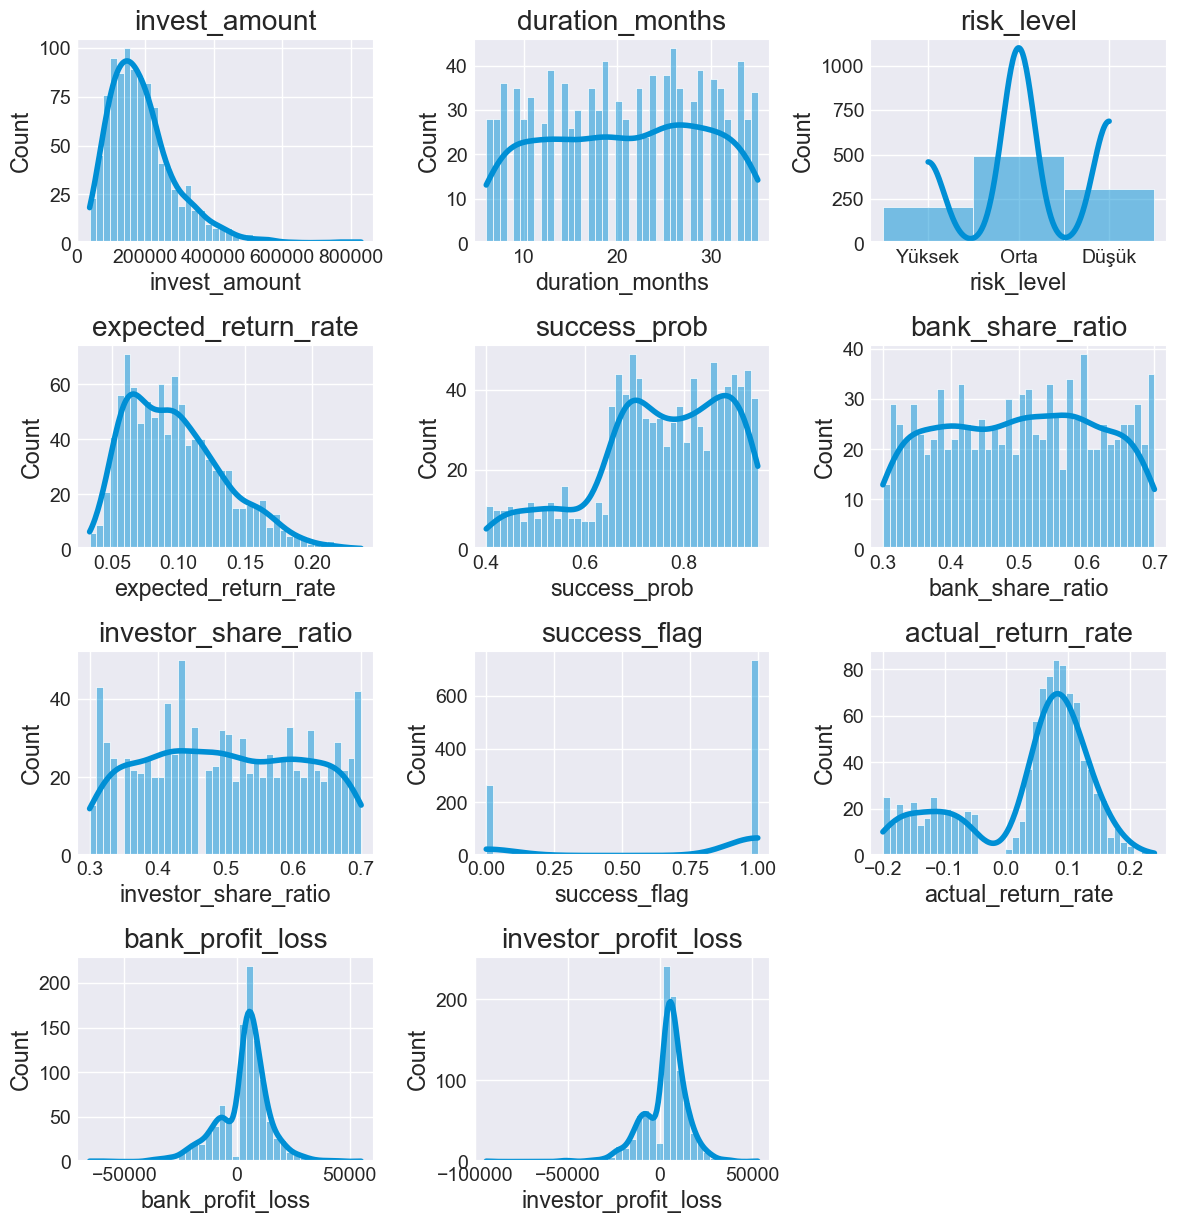

In [10]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[2:]):
    plt.subplot(5, 3, i+1)
    sns.histplot(df[c], bins=40, kde=True)
    plt.title(c)
plt.tight_layout()

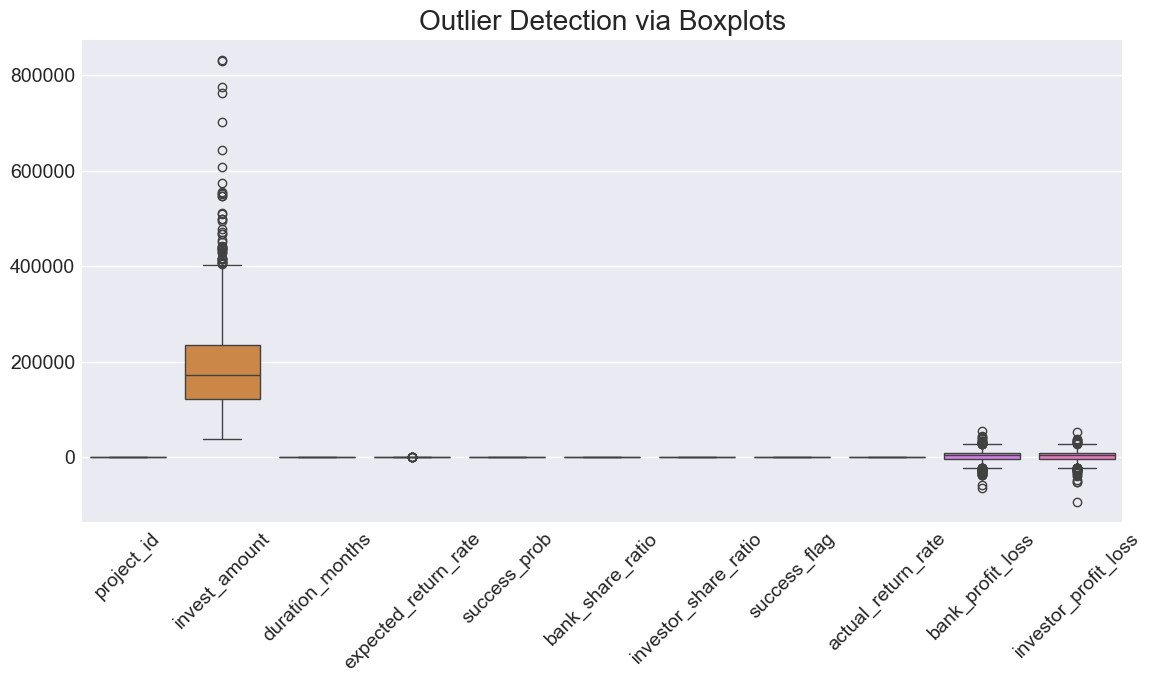

In [11]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Outlier Detection via Boxplots")
plt.xticks(rotation=45)
plt.show()

In [12]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_counts = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outlier counts per column:\n", outlier_counts)


Outlier counts per column:
 project_id               0
invest_amount           44
duration_months          0
expected_return_rate     8
success_prob             0
bank_share_ratio         0
investor_share_ratio     0
success_flag             0
actual_return_rate       0
bank_profit_loss        47
investor_profit_loss    44
dtype: int64


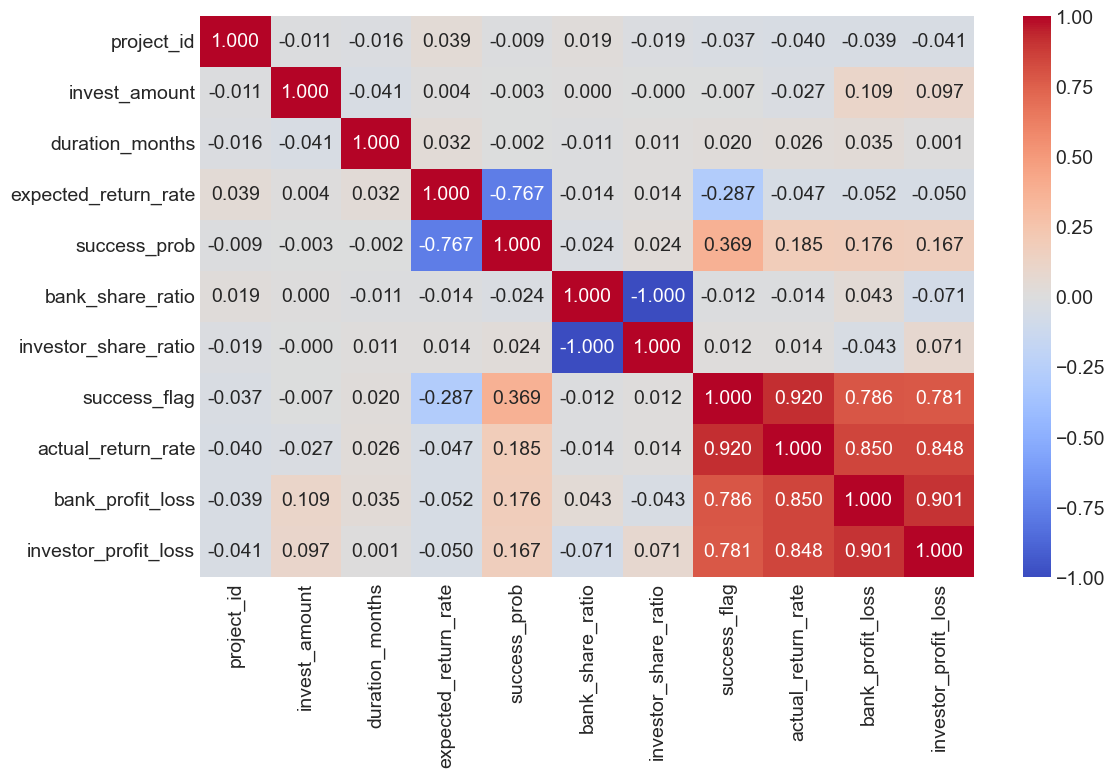

In [13]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()

In [14]:
df.corr(numeric_only=True)['actual_return_rate'].sort_values(ascending=False)

actual_return_rate      1.000000
success_flag            0.919601
bank_profit_loss        0.849757
investor_profit_loss    0.848419
success_prob            0.184553
duration_months         0.026224
investor_share_ratio    0.013869
bank_share_ratio       -0.013869
invest_amount          -0.027354
project_id             -0.040131
expected_return_rate   -0.047089
Name: actual_return_rate, dtype: float64

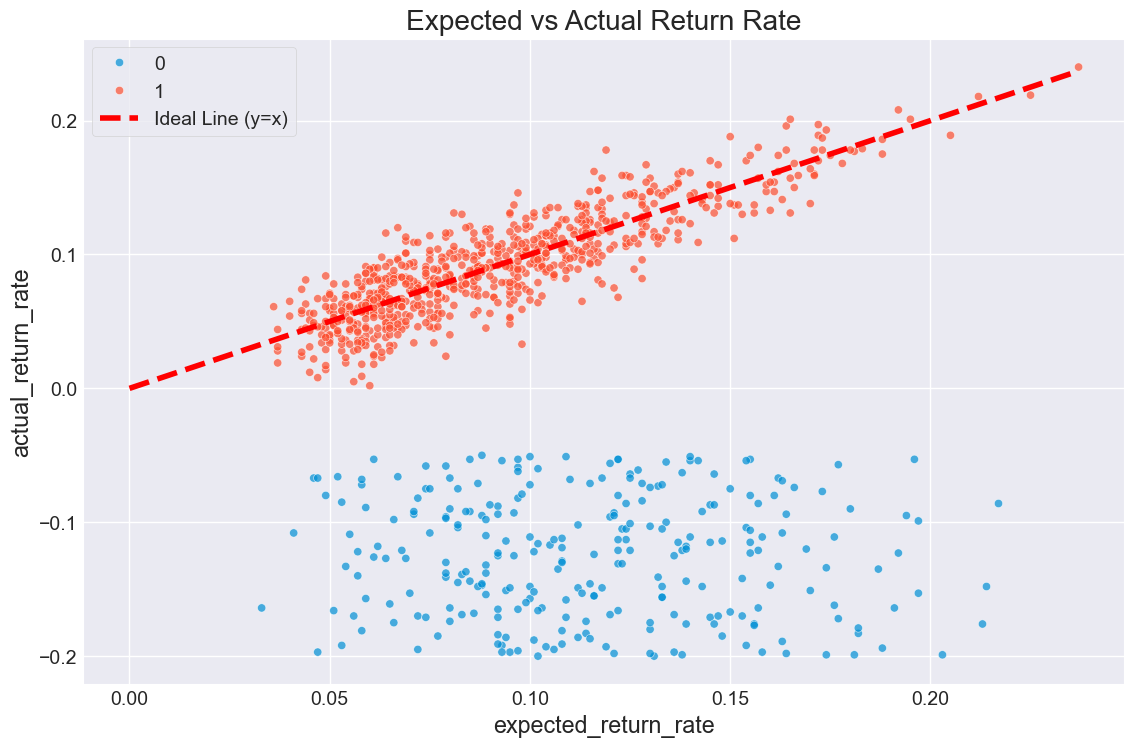

In [16]:
sns.scatterplot(data=df, x="expected_return_rate", y="actual_return_rate", hue="success_flag", alpha=0.7)
plt.plot([0, df["expected_return_rate"].max()], [0, df["expected_return_rate"].max()], 'r--', label="Ideal Line (y=x)")
plt.title("Expected vs Actual Return Rate")
plt.legend()
plt.show()


In [17]:
# başarısız yatırımlar
risky_df = df[df["success_flag"] == 0].copy()

# fark kolonu ekleme (beklenen - gerçekleşen)
risky_df["return_gap"] = risky_df["expected_return_rate"] - risky_df["actual_return_rate"]

# en riskli 10 yatırım (en yüksek fark veya en düşük actual return)
risky_top10 = risky_df.sort_values(by=["actual_return_rate", "return_gap"], ascending=[True, False]).head(10)

risky_top10[["project_id", "expected_return_rate", "actual_return_rate", "return_gap"]]

,project_id,expected_return_rate,actual_return_rate,return_gap
671,672,0.131,-0.200,0.331
579,580,0.102,-0.200,0.302
325,326,0.203,-0.199,0.402
560,561,0.181,-0.199,0.380
110,111,0.174,-0.199,0.373
369,370,0.138,-0.199,0.337
977,978,0.164,-0.198,0.362
672,673,0.130,-0.198,0.328
481,482,0.121,-0.198,0.319
264,265,0.158,-0.197,0.355


# 4. Data Preprocessing

In [18]:
X = df[['success_flag', 'bank_profit_loss', 'investor_profit_loss']]
y = df[['actual_return_rate']]

In [19]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Model Training

In [22]:
models = {
    
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

def evaluate(X_train, y_train, X_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        if 'random_state' in model.get_params():
            model.set_params(random_state=42)

        print(f'Training {model_name}...')
        y_pred = model.fit(X_train, y_train).predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
            
    report = pd.DataFrame(results).sort_values(by='r2', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [23]:
evaluate(X_train, y_train, X_test, y_test)

  0%|          | 0/2 [00:00<?, ?it/s]

Training RandomForestRegressor...
Training GradientBoostingRegressor...


,Model,mae,mse,rmse,r2
0,GradientBoostingRegressor,0.024966,0.000959,0.030961,0.917903
1,RandomForestRegressor,0.026169,0.001077,0.032820,0.907747


In [24]:
# overfitting analysis
def overfittingAnalysis(X_train, y_train, X_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        if 'random_state' in model.get_params():
            model.set_params(random_state=42)

        print(f'Training {model_name}...')
        y_train_pred = model.fit(X_train, y_train).predict(X_train)
        y_test_pred = model.fit(X_train, y_train).predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
    
        results.append({
            print(f"Train R²: {r2_train:.3f}"),
            print(f"Test R²:  {r2_test:.3f}")
        })

In [25]:
overfittingAnalysis(X_train, y_train, X_test, y_test)

  0%|          | 0/2 [00:00<?, ?it/s]

Training RandomForestRegressor...
Train R²: 0.983
Test R²:  0.908
Training GradientBoostingRegressor...
Train R²: 0.932
Test R²:  0.918


# 6. Build Pipeline with the best model, Save the model

In [26]:
preprocessor = ColumnTransformer([
    ('scaler', RobustScaler(), X.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  Index(['success_flag', 'bank_profit_loss', 'investor_profit_loss'], dtype='object'))])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [27]:
y_pred = pipeline.predict(X)

In [28]:
joblib.dump(pipeline, 'profit_sharing.pkl')

['profit_sharing.pkl']

# 7. Conclusion

In this notebook, we:

Loaded and explored the synthetic profit sharing dataset to understand how financial and risk-related factors influence the actual return rate.

Preprocessed several numerical features using Robust Scaling, and created a train/test split for model evaluation.

Compared several regression algorithms and tuned a GradientBoostingRegressor to achieve optimal performance.

Built a reusable machine learning pipeline and saved the trained model (profit_sharing.pkl) for deployment in the Streamlit application.

Key insights:

The tuned Gradient Boosting model achieved a strong R² score with low error metrics, demonstrating good generalization.

Robust scaling and basic feature selection improved model stability in the presence of outliers.
